# **Práctica 6: Fórmula de Black-Scholes**

**Introducción**

El objetivo de esta práctica es realizar una simulación de la estrategia de cobertura dinámica (Delta Hedging) para una opción de compra (Call) europea. Utilizaremos el modelo de Black-Scholes en tiempo continuo para calcular la cartera de replicación y compararemos su valor final con el payoff real de la opción en el vencimiento.


**1. Definición de Parámetros y Funciones Auxiliares**

En esta sección definimos los parámetros del mercado (tipo de interés, volatilidad, precio inicial) y la función de Black-Scholes que nos devolverá el precio de la Call y la Delta ($\Delta$), que indica cuántas unidades del activo debemos mantener para estar cubiertos.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [7]:
# Parámetros del activo y mercado

S0 = 100
sigma = 0.20
r = 0.05
mu_real = 0.15  # Deriva en el mundo real para la simulación
T = 1
N = 100         # tau = T/100
tau = T / N
K = 110
num_simulaciones = 1000

In [8]:
def calcular_black_scholes(S, K, T, r, sigma):
    if T <= 0: # Al vencimiento
        return max(S - K, 0), 0

    # Fórmulas de d1 y d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Precio de la Call (C) y Delta (Phi(d1))
    precio_call = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    delta = norm.cdf(d1)

    return precio_call, delta

**2. Simulación y Replicación (Estrategia Delta-Hedge)**

Simulación del camino: Generamos la trayectoria del precio en el mundo real.

Replicación paso a paso: Ajustamos la cartera en cada instante $n \cdot \tau$.



In [9]:
diferencias = []

for sim in range(num_simulaciones):
    # --- A) SIMULACIÓN DEL CAMINO DE PRECIOS ---
    S_camino = [S0]
    for n in range(N):
        Zn = np.random.normal(0, 1)
        exponente = (mu_real - 0.5 * sigma**2) * tau + sigma * np.sqrt(tau) * Zn
        S_nuevo = S_camino[-1] * np.exp(exponente)
        S_camino.append(S_nuevo)

    # --- B) REPLICACIÓN PASO A PASO ---
    C0, delta0 = calcular_black_scholes(S0, K, T, r, sigma)
    V_actual = C0
    delta_actual = delta0

    for n in range(N):
        S_siguiente = S_camino[n+1]

        # V(n+1) = (V_n - delta_n * S_n) * exp(r*tau) + delta_n * S_n+1
        V_actual = (V_actual - delta_actual * S_camino[n]) * np.exp(r * tau) + delta_actual * S_siguiente

        tiempo_restante = T - (n + 1) * tau
        _, delta_actual = calcular_black_scholes(S_siguiente, K, tiempo_restante, r, sigma)

    # --- C) COMPARACIÓN AL VENCIMIENTO ---
    payoff_opcion = max(S_camino[-1] - K, 0)
    diferencias.append(payoff_opcion - V_actual)


**3. Análisis de Resultados e Histograma**

Finalmente, visualizamos el error de cobertura. En un modelo ideal de tiempo continuo, la diferencia debería ser cero.

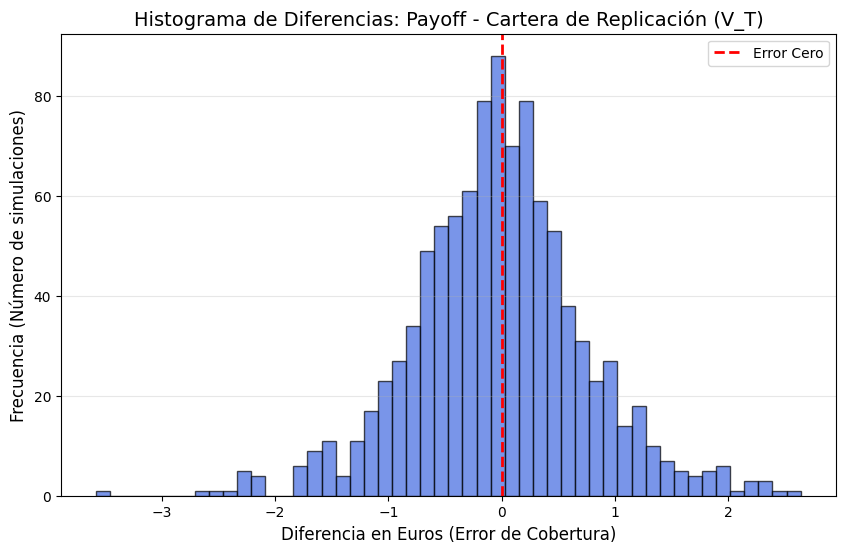

Error medio de la replicación: -0.0300
Desviación estándar del error: 0.7707


In [10]:
plt.figure(figsize=(10, 6))

# Dibujar el histograma de las diferencias (Error de cobertura)
plt.hist(diferencias, bins=50, color='royalblue', edgecolor='black', alpha=0.7)

plt.axvline(0, color='red', linestyle='dashed', linewidth=2, label='Error Cero')

# Etiquetas y título
plt.title('Histograma de Diferencias: Payoff - Cartera de Replicación (V_T)', fontsize=14)
plt.xlabel('Diferencia en Euros (Error de Cobertura)', fontsize=12)
plt.ylabel('Frecuencia (Número de simulaciones)', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Mostrar el gráfico
plt.show()

# Estadísticos útiles para el análisis
print(f"Error medio de la replicación: {np.mean(diferencias):.4f}")
print(f"Desviación estándar del error: {np.std(diferencias):.4f}")